In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
import io

import imghdr
import os

print(tf.__version__)

2.2.0-rc1


# (Don't Run this Section) Import and Download Files from Google Drive using PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1sozJHT1RI7hhpx76IMfNK559hzUN1PQ8


In [0]:
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Downloaded content "Sample upload file content"


In [0]:
sample_labels = drive.CreateFile({'id': '1YjTTFLm2Ue9UXbsFMOj0z221XMHyjBZL'})
#print('Downloaded content "{}"'.format(sample_labels.GetContentString()))

In [0]:
type(sample_labels)

NameError: ignored

In [0]:
sample_labels.head()

AttributeError: ignored

# Using Drive Mounting Instead (Tutorial: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/Bangkit Group Project (Assig #5)/DATASET/CT_SCAN/sample_labels.csv"
sample_labels = pd.read_csv(path)

In [0]:
sample_labels.head()

NameError: ignored

In [0]:
# Unzip CT_SCAN_IMG.ZIP File

In [0]:
!unzip -uq "/content/drive/My Drive/Bangkit Group Project (Assig #5)/DATASET/CT_SCAN/ct_scan_img.zip"

In [0]:
image_dir = sample_labels['Image Index'].tolist()

In [0]:
image_dir[:5]

['00000013_005.png',
 '00000013_026.png',
 '00000017_001.png',
 '00000030_001.png',
 '00000032_001.png']

In [0]:
test_dir = image_dir[:500] # Taking the first 500 Images

In [0]:
test_dir[:5]

['00000013_005.png',
 '00000013_026.png',
 '00000017_001.png',
 '00000030_001.png',
 '00000032_001.png']

In [0]:
list_files = tf.data.Dataset.list_files(test_dir)

In [0]:
list_files

<ShuffleDataset shapes: (), types: tf.string>

In [0]:
list_ds = tf.data.Dataset.from_tensor_slices(test_dir)

In [0]:
list_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [0]:
for f in list_ds.take(10):
    print(f.numpy())

b'00000013_005.png'
b'00000013_026.png'
b'00000017_001.png'
b'00000030_001.png'
b'00000032_001.png'
b'00000040_003.png'
b'00000042_002.png'
b'00000057_001.png'
b'00000061_002.png'
b'00000061_019.png'


In [0]:
def parse_data_without_augmentation(filename, IMAGE_SIZE): #, scores, IMAGE_SIZE):
    '''
    Loads the image file without any augmentation. Used for validation set.
    Args:
        filename: the filename from the record
        scores: the scores from the record
    Returns:
        an image referred to by the filename and its scores
    '''
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image#, scores

In [0]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
IMG_SIZE = 160
IMAGE_SIZE = 160
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32
IMG_HEIGHT = 160 #224
IMG_WIDTH = 160 #224
IMG_SIZE = 160
image_count = len(test_dir)
print(image_count)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

500


In [0]:
labeled_ds = list_ds.map(lambda x: parse_data_without_augmentation(x, IMAGE_SIZE), num_parallel_calls=AUTOTUNE)

In [0]:
labeled_ds

<ParallelMapDataset shapes: (160, 160, 3), types: tf.float32>

In [0]:
def show_batch(image_batch): #, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

In [0]:
image_batch = next(iter(train_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

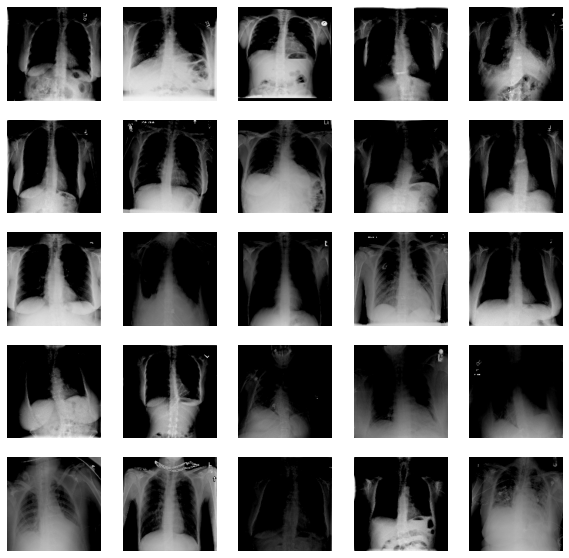

In [0]:
show_batch(image_batch.numpy())

## Getting the MobileNetV2 Model

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
feature_batch = base_model(image_batch) #(labeled_ds_3)

In [0]:
feature_batch.shape

TensorShape([32, 5, 5, 1280])

In [0]:
type(feature_batch)

tensorflow.python.framework.ops.EagerTensor

In [0]:
len(feature_batch)

32

In [0]:
len(feature_batch[0])

5

In [0]:
x = tf.constant([1., 2.])
print(type(x))            # <type 'EagerTensor'>
print(type(x.numpy()))    # <type 'numpy.ndarray'>
print(type(np.array(x)))  # <type 'numpy.ndarray'>

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
fb_np = feature_batch.numpy()

In [0]:
input_tensors = tf.convert_to_tensor(fb_np, dtype=tf.float32)
#(feature_batch, dtype=tf.float32)

In [0]:
input_tensors.shape

TensorShape([32, 5, 5, 1280])